
================= E1: RF + SMOTE vs RF TANPA SMOTE =================

=== RF + SMOTE (Best Pipeline) ===
               precision    recall  f1-score   support

   comm_fault       1.00      1.00      1.00        38
 energy_fault       1.00      1.00      1.00       206
gateway_fault       1.00      1.00      1.00       537
   loop_fault       1.00      0.99      1.00       165
       normal       1.00      1.00      1.00      1547
routing_fault       1.00      1.00      1.00       507

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000



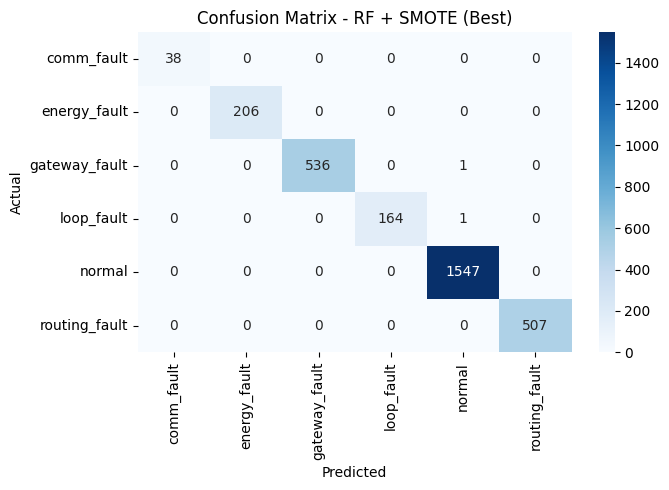


=== RF TANPA SMOTE ===
               precision    recall  f1-score   support

   comm_fault       1.00      1.00      1.00        38
 energy_fault       1.00      1.00      1.00       206
gateway_fault       1.00      1.00      1.00       537
   loop_fault       1.00      0.99      1.00       165
       normal       1.00      1.00      1.00      1547
routing_fault       1.00      1.00      1.00       507

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000



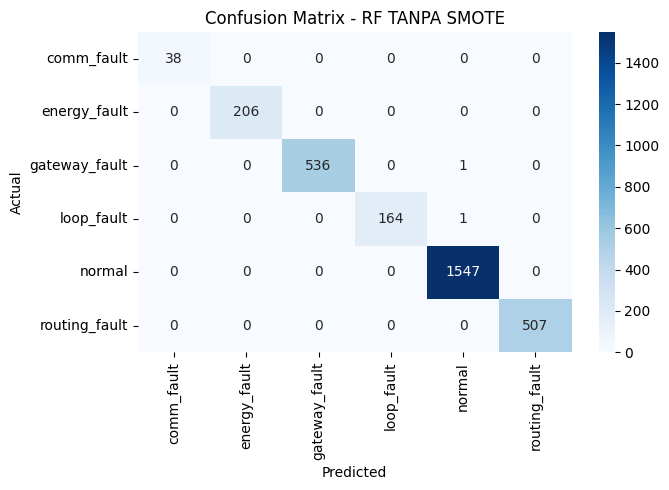


================= E2: NOISE INJECTION TEST =================

=== TANPA NOISE ===
               precision    recall  f1-score   support

   comm_fault       1.00      1.00      1.00        38
 energy_fault       1.00      1.00      1.00       206
gateway_fault       1.00      1.00      1.00       537
   loop_fault       1.00      0.99      1.00       165
       normal       1.00      1.00      1.00      1547
routing_fault       1.00      1.00      1.00       507

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000


=== DENGAN NOISE 5% ===
               precision    recall  f1-score   support

   comm_fault       0.65      0.63      0.64        38
 energy_fault       0.74      0.72      0.73       206
gateway_fault       0.92      0.92      0.92       537
   loop_fault       0.85      0.83      0.84       165
       normal       0.91      0.91      0.91      1547
routing_

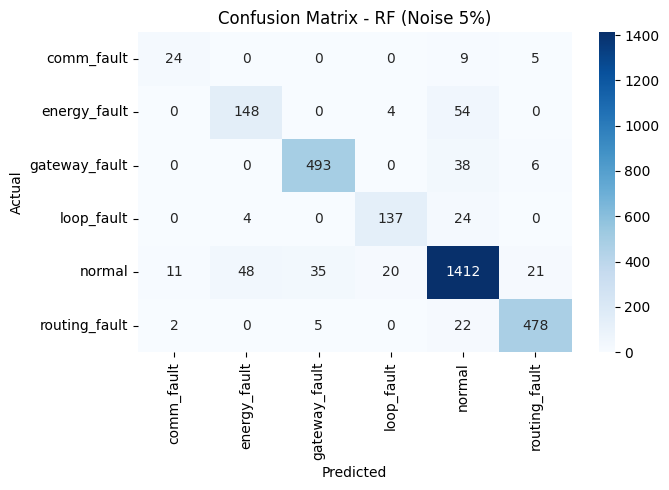


================= E3: FEATURE ABLATION =================
Baseline F1-macro: 0.9992304208401565

--- DROP FEATURE: energy_level ---
F1-macro: 0.8866651406685241

--- DROP FEATURE: energy_drop_rate ---
F1-macro: 0.9279958641229541

--- DROP FEATURE: latency_ms ---
F1-macro: 0.9338561254672997

--- DROP FEATURE: end_to_end_delay ---
F1-macro: 0.8210833594471555

--- DROP FEATURE: packet_loss ---
F1-macro: 0.7771323084033913

--- DROP FEATURE: throughput_kbps ---
F1-macro: 0.9385876471716531

=== RINGKASAN ABLATION ===
energy_level: 0.8867
energy_drop_rate: 0.9280
latency_ms: 0.9339
end_to_end_delay: 0.8211
packet_loss: 0.7771
throughput_kbps: 0.9386

================= E4: MODEL DUA TAHAP =================

=== STAGE 1: NORMAL vs FAULT ===
              precision    recall  f1-score   support

       fault       1.00      1.00      1.00      1453
      normal       1.00      1.00      1.00      1547

    accuracy                           1.00      3000
   macro avg       1.00      1.00  

In [ ]:
# ============================================================
# EKSPERIMEN LANJUTAN (E1–E5) DENGAN PENJELASAN LENGKAP
# ============================================================

# 📌 Mengapa semua eksperimen dipisah ke file ini?
# Supaya model_training.py tetap bersih untuk pelatihan model utama,
# sedangkan file ini khusus untuk analisis dan eksperimen lanjutan.
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib

# ============================================================
# 1. LOAD DATASET & TRAIN TEST SPLIT
# ============================================================
# Dataset sama persis seperti training utama
df = pd.read_excel("dataset_labeled_wsn.xlsx")

X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

label_order = sorted(y.unique())

# ============================================================
# 2. LOAD MODEL TERBAIK (HASIL TUNING RANDOM FOREST)
# ============================================================
# Pipeline berisi:
# - StandardScaler
# - SMOTE
# - RandomForestClassifier
# disimpan waktu training utama
best_rf_pipeline = joblib.load("rf_wsn_multiclass_best_pipeline.pkl")

rf_final = best_rf_pipeline.named_steps["rf"]


# ============================================================
# Helper untuk plot confusion matrix
# ============================================================
def plot_confusion(cm, labels, title):
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=labels,
                yticklabels=labels,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ============================================================
# E1 — RF + SMOTE vs RF tanpa SMOTE
# ============================================================
print("\n================= E1: RF + SMOTE vs RF TANPA SMOTE =================")

# E1A — Model RF terbaik (pipeline: scaler + SMOTE + RF)
y_pred_best = best_rf_pipeline.predict(X_test)
print("\n=== RF + SMOTE (Best Pipeline) ===")
print(classification_report(y_test, y_pred_best, target_names=label_order))
plot_confusion(
    confusion_matrix(y_test, y_pred_best, labels=label_order),
    label_order,
    "Confusion Matrix - RF + SMOTE (Best)"
)

# E1B — RF tanpa SMOTE (pakai class_weight='balanced')
# Tujuannya untuk melihat apakah SMOTE benar-benar memberikan peningkatan.
rf_nosmote = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=rf_final.n_estimators,
        max_depth=rf_final.max_depth,
        min_samples_leaf=rf_final.min_samples_leaf,
        min_samples_split=rf_final.min_samples_split,
        max_features=rf_final.max_features,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

rf_nosmote.fit(X_train, y_train)
y_pred_nosmote = rf_nosmote.predict(X_test)

print("\n=== RF TANPA SMOTE ===")
print(classification_report(y_test, y_pred_nosmote, target_names=label_order))
plot_confusion(
    confusion_matrix(y_test, y_pred_nosmote, labels=label_order),
    label_order,
    "Confusion Matrix - RF TANPA SMOTE"
)


# ============================================================
# E2 — Noise Injection Test (Robustness)
# ============================================================
print("\n================= E2: NOISE INJECTION TEST =================")

# E2A — Prediksi asli (tanpa noise)
print("\n=== TANPA NOISE ===")
print(classification_report(y_test, y_pred_best, target_names=label_order))

# E2B — Menambahkan noise 5% ke fitur
noise_level = 0.05
X_range = X_test.max(axis=0) - X_test.min(axis=0)

noise = np.random.normal(
    loc=0.0,
    scale=noise_level * X_range.values,
    size=X_test.shape
)

X_test_noisy = X_test.values + noise

# FIX WARNING — ubah array menjadi DataFrame dengan nama kolom
X_test_noisy_df = pd.DataFrame(X_test_noisy, columns=X.columns)

y_pred_noisy = best_rf_pipeline.predict(X_test_noisy_df)

print("\n=== DENGAN NOISE 5% ===")
print(classification_report(y_test, y_pred_noisy, target_names=label_order))

plot_confusion(
    confusion_matrix(y_test, y_pred_noisy, labels=label_order),
    label_order,
    "Confusion Matrix - RF (Noise 5%)"
)


# ============================================================
# E3 — Feature Ablation Test
# ============================================================
print("\n================= E3: FEATURE ABLATION =================")

features = X.columns.tolist()
baseline_f1 = f1_score(y_test, y_pred_best, average="macro")

print("Baseline F1-macro:", baseline_f1)

ablation_results = []

for feat in features:
    print(f"\n--- DROP FEATURE: {feat} ---")

    X_train_drop = X_train.drop(columns=[feat])
    X_test_drop  = X_test.drop(columns=[feat])

    rf_ablation = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("rf", RandomForestClassifier(
            n_estimators=rf_final.n_estimators,
            max_depth=rf_final.max_depth,
            min_samples_leaf=rf_final.min_samples_leaf,
            min_samples_split=rf_final.min_samples_split,
            max_features=rf_final.max_features,
            n_jobs=-1,
            random_state=42
        ))
    ])

    rf_ablation.fit(X_train_drop, y_train)
    pred_ablation = rf_ablation.predict(X_test_drop)

    f1_val = f1_score(y_test, pred_ablation, average="macro")
    ablation_results.append((feat, f1_val))
    print("F1-macro:", f1_val)

# Ringkasan
print("\n=== RINGKASAN ABLATION ===")
for feat, f1v in ablation_results:
    print(f"{feat}: {f1v:.4f}")


# ============================================================
# E4 — Model Dua Tahap
# ============================================================
print("\n================= E4: MODEL DUA TAHAP =================")

# Membuat label biner: normal vs fault
y_binary = y.replace({
    "normal": "normal",
    "energy_fault": "fault",
    "gateway_fault": "fault",
    "routing_fault": "fault",
    "loop_fault": "fault",
    "comm_fault": "fault"
})

# Split untuk tahap dua
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y_binary,
    test_size=0.2,
    stratify=y_binary,
    random_state=42
)

# Tahap 1 — Normal vs Fault
rf_stage1 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=150,
        max_depth=5,
        class_weight="balanced",
        random_state=42
    ))
])

rf_stage1.fit(X_train_b, y_train_b)
y_pred_stage1 = rf_stage1.predict(X_test_b)

print("\n=== STAGE 1: NORMAL vs FAULT ===")
print(classification_report(y_test_b, y_pred_stage1))

# Ambil hanya data FAULT untuk tahap 2
fault_mask_train = (y_train_b == "fault")
fault_mask_test  = (y_test_b == "fault")

X_train_fault = X_train_b[fault_mask_train]
X_test_fault  = X_test_b[fault_mask_test]

# FIX INDEX — ambil label multiclass original sesuai index y_train_b
y_train_fault = y.loc[y_train_b.index][fault_mask_train]
y_test_fault  = y.loc[y_test_b.index][fault_mask_test]

rf_stage2 = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        max_features="sqrt",
        random_state=42
    ))
])

rf_stage2.fit(X_train_fault, y_train_fault)
pred_stage2 = rf_stage2.predict(X_test_fault)

fault_classes = [c for c in label_order if c != "normal"]

print("\n=== STAGE 2: KLASSIFIKASI JENIS FAULT ===")
print(classification_report(y_test_fault, pred_stage2, target_names=fault_classes))


# ============================================================
# E5 — Inference Time Test
# ============================================================
print("\n================= E5: INFERENCE TIME =================")

n_samples = 10000

# Perbanyak X_test sampai minimal 10.000 sampel
X_bench = np.tile(X_test.values, (int(np.ceil(n_samples / len(X_test))), 1))[:n_samples]

# FIX WARNING — ubah jadi DataFrame
X_bench_df = pd.DataFrame(X_bench, columns=X.columns)

start = time.perf_counter()
best_rf_pipeline.predict(X_bench_df)
end = time.perf_counter()

total_time = end - start
print(f"Total waktu prediksi untuk {n_samples} sampel: {total_time:.4f} detik")
print(f"Per sampel: {(total_time/n_samples)*1000:.4f} ms")
